In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Model, Sequential
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import tensorflow as tf

In [ ]:
target_size = (224, 224)
anno_xml_folder = '/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/xmls'
image_folder = '/content/drive/MyDrive/oxford-iiit-pet/images/images'
anno_txt_file = '/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/list.txt'

In [ ]:
def bbx_coo(anno_xml):

  tree = ET.parse(anno_xml)
  root = tree.getroot()
  path = root.find("./object/bndbox")
  xmin = int(path.find('xmin').text)
  ymin = int(path.find('ymin').text)
  xmax = int(path.find('xmax').text)
  ymax = int(path.find('ymax').text)
  bbx_coo = (xmin, ymin, xmax, ymax)

  return bbx_coo

def preprosessing_images(image_path, bbx_coo, target_size):
  image = Image.open(image_path)

  #Padding & updating bbx coordinations
  xmin, ymin, xmax, ymax = bbx_coo
  w, h =image.size

  w_padd_start =  h_padd_start = w_padd_end = h_padd_end = 0

  if h>w:
    w_padd_start = (h-w)//2
    w_padd_end = w_padd_start + (h-w)%2

  elif h<w:
    h_padd_start = (w-h)//2
    h_padd_end = h_padd_start + (w-h)%2

  image = ImageOps.expand(image, (w_padd_start, h_padd_start, w_padd_end, h_padd_end))

  xmin += w_padd_start
  xmax += w_padd_start
  ymin += h_padd_start
  ymax += h_padd_start

  #Resize & updating bbx coordinations
  w, h =image.size
  image = image.resize(target_size)

  xmin *= target_size[0]/w
  xmax *= target_size[0]/w
  ymin *= target_size[1]/h
  ymax *= target_size[1]/h

  bbx_resized = (xmin, ymin, xmax, ymax)
  image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)

  return (image_data, bbx_resized)

In [ ]:
def processing_data():
  f = open(anno_txt_file, 'r')
  anno_lines = f.readlines()
  counter = 0
  c_dog=0
  c_cat=0

  pet_data_list = []
  for line in anno_lines:
    #skip the comment lines
    if line[0]=="#":
      continue

    line_list = line.split()
    path_to_image = os.path.join(image_folder, line_list[0] + '.jpg')
    path_to_xml = os.path.join(anno_xml_folder, line_list[0] + '.xml')
    species = int(line_list[2])-1

    try:
      original_bbx = bbx_coo(path_to_xml)
      image_data, bbx = preprosessing_images(path_to_image, original_bbx, target_size)
      pet_data = (image_data, species, bbx)
      pet_data_list.append(pet_data)

      counter += 1
      if counter%100==0:
        print(str(counter)+' is done')
    except:
      print(str(line_list[0]) + ' xml file does not exist')

  np.random.shuffle(pet_data_list)
  pet_data_arry = np.array(pet_data_list)

In [ ]:
data_pros = np.load('/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/data.npy', allow_pickle=True)

In [ ]:
c_dog=0
c_cat=0
x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []
validation_split = 0.2
for image, species, bounding_box in data_pros:

  #equalized distribution of data in both classes
  if species == 0:
    c_cat+=1
    if c_cat>700:
      continue
  else:
    c_dog += 1
    if c_dog>700:
      continue

  if np.random.random() > validation_split:
    x_train.append(preprocess_input(image))
    y_class_train.append(species)
    y_box_train.append(bounding_box)
  else:
    x_validation.append(preprocess_input(image))
    y_class_validation.append(species)
    y_box_validation.append(bounding_box)
x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)
x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

In [ ]:
base_model2 = Xception(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
for layer in base_model2.layers[:]:
    layer.trainable = False
chopped_Xception = Model(inputs=[base_model2.input], outputs=[base_model2.layers[90].output])
#classifier net
classification_output2 = GlobalAveragePooling2D()(chopped_Xception.output)
classification_output2 = Dense(units=1, activation='sigmoid')(classification_output2)
#detector net
localization_output2 = Flatten()(chopped_Xception.output)
localization_output2 = Dense(units=4, activation='relu')(localization_output2)
model2 = Model(inputs=[chopped_Xception.input], outputs=[classification_output2, localization_output2])


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.1)
model2.compile(opt, metrics=['accuracy'],loss=['binary_crossentropy', 'mse'],loss_weights=[800, 1]  )

history3=model2.fit(x_train, [y_class_train, y_box_train], validation_data=(x_validation, [y_class_validation, y_box_validation]),epochs=10,verbose=True)

model2.save('/content/drive/MyDrive/oxford-iiit-pet/annotations/annotations/model1.h5')

Epoch 1/10
36/36 [==============================] - 200s 5s/step - loss: 1066177.5000 - dense_loss: 1.9636 - dense_1_loss: 1064606.1250 - dense_accuracy: 0.6105 - dense_1_accuracy: 0.0393 - val_loss: 13059.8633 - val_dense_loss: 0.6284 - val_dense_1_loss: 12557.1748 - val_dense_accuracy: 0.7131 - val_dense_1_accuracy: 0.0000e+00
Epoch 2/10
36/36 [==============================] - 193s 5s/step - loss: 12599.1699 - dense_loss: 0.4627 - dense_1_loss: 12228.9961 - dense_accuracy: 0.7817 - dense_1_accuracy: 0.0000e+00 - val_loss: 13846.5098 - val_dense_loss: 1.6117 - val_dense_1_loss: 12557.1748 - val_dense_accuracy: 0.4726 - val_dense_1_accuracy: 0.0000e+00
Epoch 3/10
36/36 [==============================] - 194s 5s/step - loss: 12610.5352 - dense_loss: 0.4769 - dense_1_loss: 12228.9961 - dense_accuracy: 0.7904 - dense_1_accuracy: 0.0000e+00 - val_loss: 13007.9473 - val_dense_loss: 0.5635 - val_dense_1_loss: 12557.1748 - val_dense_accuracy: 0.7384 - val_dense_1_accuracy: 0.0000e+00
Epoch 4

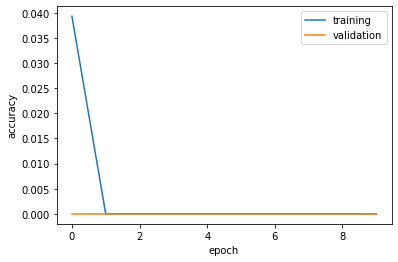

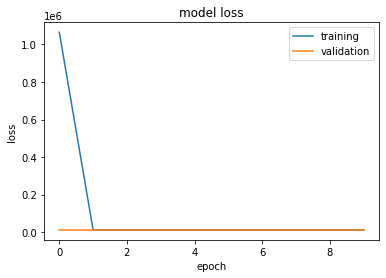

In [ ]:
def plot_training_history(history, model):
  plt.plot(history.history['dense_1_accuracy'])
  plt.plot(history.history['val_dense_1_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
  plt.plot(history.history['dense_1_loss'])
  plt.plot(history.history['val_dense_1_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
plot_training_history(history3, model2)

1/1 [==============================] - 1s 795ms/step
[0. 0. 0. 0.]
it is a dog by ResNet
intersection of union = 0.0


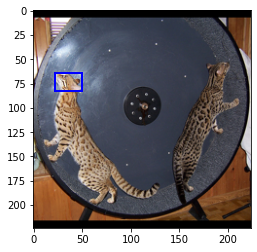

In [ ]:
def plot_with_box(model):
  i = np.random.randint(len(data_pros))
  img, species, true_bounding_box = data_pros[i]
  pred = model.predict(img.reshape(-1,224,224,3))
  bounding_box=pred[1][0]
  print(pred[1][0])

  if pred[0][0] < .5:
    print("it is a Cat by ResNet")
  else:
    print("it is a dog by ResNet")

  fig,ax = plt.subplots(1)
  ax.imshow(img)
  # predicted bbx rectangle
  boxA = patches.Rectangle((bounding_box[0], bounding_box[1]),
  bounding_box[2] - bounding_box[0],
  bounding_box[3] - bounding_box[1],
  linewidth=3, edgecolor='y', facecolor='none')

  ax.add_patch(boxA)

  #ground truth bbx rectangle
  boxB = patches.Rectangle((true_bounding_box[0], true_bounding_box[1]),
  true_bounding_box[2] - true_bounding_box[0],
  true_bounding_box[3] - true_bounding_box[1],
  linewidth=2, edgecolor='b', facecolor='none')

  ax.add_patch(boxB)

  #calculating IOU
  xA = max(bounding_box[0], true_bounding_box[0])
  yA = max(bounding_box[1], true_bounding_box[1])
  xB = min(bounding_box[2], bounding_box[2])
  yB = max(bounding_box[3], bounding_box[3])
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  boxAArea = (bounding_box[2] - bounding_box[0] + 1) * (bounding_box[3] - bounding_box[1] + 1)
  boxBArea = (bounding_box[2] - bounding_box[0] + 1) * (bounding_box[3] - bounding_box[1] + 1)
  iou =interArea/float(boxAArea+boxBArea-interArea)

  print('intersection of union =',iou)
  plt.show()

plot_with_box(model2)